In [1]:
import os  
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.preprocessing.image import img_to_array, load_img  
from tensorflow.keras.utils import to_categorical  
from sklearn.model_selection import train_test_split  
import numpy as np  
import matplotlib.pyplot as plt  
import math  
import shutil  
from tensorflow.keras.preprocessing import image  
from tensorflow.keras import layers, models  

# You might need to adjust this base_dir to your dataset structure  
base_dir = 'dataset/training'  
augmented_dir = 'dataset/augmented'  
test_dir = 'dataset/test'

classes = ['oranges', 'bananas']  
batch_size = 32
# Clean up the augmented directory (optional)  
if os.path.exists(augmented_dir):  
    shutil.rmtree(augmented_dir)
    
os.makedirs(augmented_dir)
os.makedirs(f"{augmented_dir}/oranges")
os.makedirs(f"{augmented_dir}/bananas")
  
# Image dimensions  
img_width, img_height = 96, 96  
# Setting the number of augmentations per image  
augmentations_per_image = 15  
  
# Initialize the image data generator for augmentation  
datagen = ImageDataGenerator(  
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  
)  
  
def save_augmented_images(class_name):  
    image_dir = os.path.join(base_dir, class_name)
    images = [img for img in os.listdir(image_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]  

    for img_name in images:  
        img_path = os.path.join(base_dir, class_name, img_name)  
        img = load_img(img_path)  
        img = img.resize((img_width, img_height))  
        x = img_to_array(img)  
        x = np.expand_dims(x, axis=0)  
        i = 0  
        for _ in datagen.flow(x, batch_size=1,  
                              save_to_dir=os.path.join(augmented_dir, class_name),  
                              save_prefix='aug',  
                              save_format='jpeg'):  
            i += 1  
            if i >= augmentations_per_image:  
                break  
  
# Apply augmentations and save images  
for cls in classes:  
    save_augmented_images(cls)  
  
# Load the augmented dataset  
train_datagen = ImageDataGenerator(  
    rescale=1./255,  
    validation_split=0.2  # using 20% of the data for validation  
)  
  
train_generator = train_datagen.flow_from_directory(  
    augmented_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    subset='training'  
)  
  
validation_generator = train_datagen.flow_from_directory(  
    augmented_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    subset='validation'  
) 

test_datagen = ImageDataGenerator(rescale=1./255)  
  
test_generator = test_datagen.flow_from_directory(  
    directory=test_dir,  # Make sure this points to your test dataset directory  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical'  # or 'categorical' if you have more than two classes  
)  
  
# Use the model's `fit` method on the generator since it's now been updated to use the pre-augmented dataset  
steps_per_epoch = np.ceil(train_generator.samples / batch_size)  
validation_steps = np.ceil(validation_generator.samples / batch_size)  

# Model architecture  
model = models.Sequential([ 
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),  
    layers.MaxPooling2D(2, 2),    
    layers.Conv2D(32, (3, 3), activation='relu'),  
    layers.MaxPooling2D(2, 2),    
    layers.Conv2D(64, (3, 3), activation='relu'),  
    layers.MaxPooling2D(2, 2),   
    layers.GlobalAveragePooling2D(),   
    layers.Dense(128, activation='relu'),    
    # Updating the output layer for 2 classes with softmax  
    layers.Dense(2, activation='softmax')      
])  
  
# Compiling the model  
model.compile(optimizer='adam',  
              loss='categorical_crossentropy',  # Since it's binary classification  
              metrics=['accuracy'])  

model.summary()

Found 907 images belonging to 2 classes.
Found 226 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496     


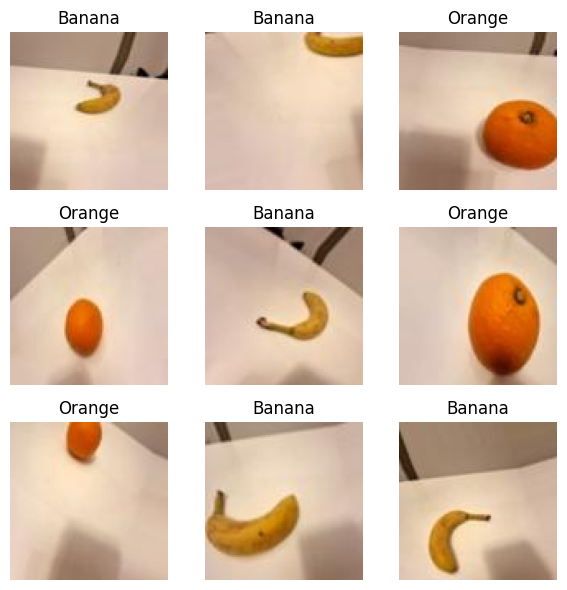

In [9]:
def plot_images_from_generator(generator, num_images=8):  
    """  
    This function plots a series of images returned by an ImageDataGenerator.  
  
    Parameters:  
    - generator: The ImageDataGenerator instance to plot images from.  
    - num_images: Number of images to display.  
    """  
      
    # Get a batch of images  
    imgs, labels = next(generator)  # 'next' retrieves the next batch  
      
    # Determine the grid size needed  
    nrows = int(num_images ** 0.5)  
    ncols = int(np.ceil(num_images / nrows))  
      
    # Set up matplotlib fig, and size it to fit `num_images` images  
    plt.figure(figsize=(6, 6))  
    for i in range(num_images):  
        plt.subplot(nrows, ncols, i + 1)  
        # Rescale images to display them correctly  
        img = imgs[i] * 255  # Assuming the generator rescales images by 1/255  
        plt.imshow(img.astype(np.uint8))  
          
        # Adjusting label display for possibly one-hot encoded labels  
        if generator.class_mode == 'categorical':  
            # For one-hot encoded labels, find the index of the max value  
            label = np.argmax(labels[i])  
            if label == 0:  
                plt.title('Banana')  
            else:  
                plt.title('Orange')  
        else:  
            # For binary labels  
            if labels[i] == 1:  
                plt.title('Orange')  
            else:  
                plt.title('Banana')  
  
        plt.axis('off')  
    plt.tight_layout()  
    plt.show()  
  
# Assumes 'train_generator' is already instantiated as per the previous discussion  
plot_images_from_generator(train_generator, num_images=9)  

In [4]:
history = model.fit(  
    train_generator,  
    steps_per_epoch=steps_per_epoch,  
    validation_data=validation_generator,  
    validation_steps=validation_steps,  
    epochs=10  # Number of epochs  
)  

Epoch 1/10
29/29 [==============================] - 1s 40ms/step - loss: 0.6876 - accuracy: 0.5127 - val_loss: 0.6685 - val_accuracy: 0.7478
Epoch 2/10
29/29 [==============================] - 1s 37ms/step - loss: 0.5851 - accuracy: 0.7387 - val_loss: 0.4612 - val_accuracy: 0.8097
Epoch 3/10
29/29 [==============================] - 1s 38ms/step - loss: 0.2931 - accuracy: 0.8897 - val_loss: 0.1824 - val_accuracy: 0.9248
Epoch 4/10
29/29 [==============================] - 1s 38ms/step - loss: 0.1286 - accuracy: 0.9570 - val_loss: 0.0964 - val_accuracy: 0.9646
Epoch 5/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0658 - accuracy: 0.9824 - val_loss: 0.0526 - val_accuracy: 0.9867
Epoch 6/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0507 - accuracy: 0.9857 - val_loss: 0.0392 - val_accuracy: 0.9912
Epoch 7/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0423 - accuracy: 0.9857 - val_loss: 0.0653 - val_accuracy: 0.9735
Epoch 8/10
29

1/1 [==============================] - 0s 43ms/step


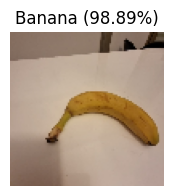

1/1 [==============================] - 0s 12ms/step


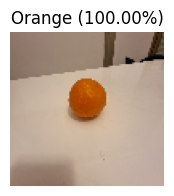

In [7]:
def predict_and_display_image(image_path, model, classes=['Banana', 'Orange']):    
    # Loading and preprocessing image    
    img = image.load_img(image_path, target_size=(img_width, img_height))    
    img_array = image.img_to_array(img)    
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch    
    img_array /= 255.0  # Rescale image values to [0, 1]    
    
    # Make prediction    
    predictions = model.predict(img_array)    
    predicted_class_index = np.argmax(predictions, axis=1)[0]  # Get index of the predicted class  
    prediction_score = predictions[0][predicted_class_index]  # Get the prediction score  
    
    # Determine the class based on the predicted index  
    class_prediction = classes[predicted_class_index]    
    score = prediction_score * 100  
  
    plt.figure(figsize=(2, 2))    
    
    # Displaying the image    
    plt.imshow(img)    
    plt.axis('off')  # Don't show axes for images    
    plt.title(f'{class_prediction} ({score:.2f}%)')    
    plt.show()    
  
predict_and_display_image("test/banana.4piv5bho.ingestion-d59dc547b-j6mhk.jpg", model)  
predict_and_display_image("test/orange.4piv9lmk.ingestion-d59dc547b-94nn2.jpg", model)  


In [6]:
test_loss, test_accuracy = model.evaluate(test_generator)  
print(f'Test accuracy: {test_accuracy*100:.2f}%')

1/1 [==============================] - 0s 39ms/step - loss: 0.0065 - accuracy: 1.0000
Test accuracy: 100.00%


In [8]:
model_save_path = "output/saved_model"  
tf.saved_model.save(model, model_save_path)

model.save('output/model.h5')

# Load the saved model  
saved_model = tf.keras.models.load_model('output/model.h5')  
  
# Convert the model to TensorFlow Lite format  
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)  
tflite_model = converter.convert()  
  
# Save the converted model to a .tflite file  
with open('output/model.tflite', 'wb') as f_out:  
    f_out.write(tflite_model)  

INFO:tensorflow:Assets written to: output/saved_model/assets


INFO:tensorflow:Assets written to: output/saved_model/assets
/Users/m/dev/6be709c0/oc-ai-engineer/OC/P9/v2-cnn-classifier/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmpw8n6_a_u/assets


INFO:tensorflow:Assets written to: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmpw8n6_a_u/assets
2024-04-11 18:53:54.909536: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-04-11 18:53:54.909548: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-04-11 18:53:54.909763: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmpw8n6_a_u
2024-04-11 18:53:54.910611: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-04-11 18:53:54.910617: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/tmpw8n6_a_u
2024-04-11 18:53:54.912330: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-04-11 18:53:54.913332: I tensorflow/cc/saved_model/load